# Custo Eleitoral dos Candidatos

## Qual a forma mais barata de eleger um candidato alinhado?

Essa é a grande pergunta que todo doador se faz. Supondo que um candidato qualquer seja, de fato, alinhado, precisamos pensar em alguns outros fatores.

A análise mais simples a ser feita é simplesmente dividir o custo total da campanha pelo número de votos, o famoso "custo por voto". 

Mas esse indicador tem problemas. Dadas as regras do sistema eleitoral brasileiro, na maioria dos casos o candidato não atinge o número de votos necessários para se conseguir a cadeira (i.e. o coefieciente eleitoral) sozinho. 

Um candidato pode ter um custo por voto baixíssimo, mas estar em um partido que não o permitirá atingir o coeficiente – ou porque faltam muitos votos para um partido obter a cadeira, ou porque é muito caro. 

Para isso, criamos um indicador chamado __CUSTO MARGINAL AGREGADO__, que leva em consideração o custo do voto do candidato e o custo de votos do partido para atingir o coeficiente eleitoral. 


# Custo Marginal Agregado


### Como funciona o indicador?

Suponha que o coeficiente eleitoral seja de 20.000 votos e que o candidato X tenha feito 5.000 votos. O custo por voto do candidato é 1 real por voto, e o custo por voto do partido Y é de 5 reais. O partido (incluindo o candidato) fez 30.000 votos. 

O custo marginal agregado é uma média ponderada entre o custo que o candidato teria para atingir o coeficiente eleitoral sozinho (o Custo Marginal do Candidato) e o custo que o partido teria para alcançar uma cadeira adicional no parlamento (o Custo Marginal do Partido).

Para o candidato do nosso exemplo o Custo Marginal do Candidato é 15.000 votos * 1 real por voto = 15000 reais
O Custo Marginal do Partido é 10.000 votos * 5 reais por voto = 50.000 reais. 

Para a ponderação, levamos em consideração que o candidato X seria responsável por 1 em cada 6 votos dos 10.000 que faltam para o partido atingir o coeficiente eleitoral mais uma vez. Portanto, o custo do partido tem peso 5/6 e o custo por voto do candidato tem peso 1/6. 

Ou seja: ( 1/6 * 15.000 votos * R$ 1/voto ) + ( 5/6 * 10000 * R$ 5/voto ) 

No final, o Custo Marginal Agregado é dado pela fórmula:

QVC / QVP * CMC + [1-(QVC/QVP) * CMP]


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Abrir os dados do TSE com as votações dos candidatos e excluímos as colunas irrelevantes

bu = pd.read_csv('Desktop/Python/Data/bweb_1t_RS_181120201549.csv', delimiter=';', encoding='latin-1')

bu = bu.drop(columns={'DT_GERACAO', 'HH_GERACAO','NR_TURNO', 'CD_ELEICAO',
                      'ANO_ELEICAO','CD_PLEITO','DT_PLEITO',
                      'CD_CARGO_PERGUNTA','CD_TIPO_URNA', 'CD_TIPO_VOTAVEL', 
                      'NR_URNA_EFETIVADA', 'CD_CARGA_1_URNA_EFETIVADA',
                      'DT_CARGA_URNA_EFETIVADA','DS_CARGO_PERGUNTA_SECAO',
                      'DT_ABERTURA', 'DT_ENCERRAMENTO', 
                      'QT_ELEITORES_BIOMETRIA_NH','NR_JUNTA_APURADORA', 
                      'NR_TURMA_APURADORA'
                      })

In [2]:
#Selecionamos apenas a eleição de Porto Alegre
poa = pd.DataFrame(bu[bu['NM_MUNICIPIO'] == 'PORTO ALEGRE'])

#Selecionando apenas os candidatos do Legislativo
leg = pd.DataFrame(poa[poa['DS_CARGO_PERGUNTA'] == 'Vereador'])

#Obtemos a votação para cada candidato
votos = leg.groupby('NM_VOTAVEL')['QT_VOTOS'].sum()

#Calculamos o coeficiente eleitoral: Total de Votos Válidos / Número de Cadeiras para Porto Alegre (36)
ce = int(leg['QT_VOTOS'].sum() / 36)

print('O Coeficiente Eleitoral para Porto Alegre é:', ce)

O Coeficiente Eleitoral para Porto Alegre é: 20125


In [3]:
#Importamos a lista de candidatos
cand = pd.read_csv('Downloads/consulta_cand_2020_RS.csv', 
                delimiter=';', encoding='latin-1'
                )
# Importamos a planilha de prestação de Contas do TSE
dc = pd.read_csv('Downloads/despesas_contratadas_candidatos_2020_RS.csv', 
                delimiter=';', encoding='latin-1'
                )
#Correção da Planilha para que os dados sejam convertidos para número e sejam passíveis de soma
dc['VR_DESPESA_CONTRATADA'] = dc['VR_DESPESA_CONTRATADA'].str.replace('[A-Za-z]', '').str.replace('.', '').str.replace(',', '.').astype(float)

# Indexando pelo sequencial do candidato, gerado pelo TSE
cand = cand.set_index('SQ_CANDIDATO')

# Somando todos os gastos contratados por cada candidato e adicionando como variável na lista de candidatos
gastos = dc.groupby('SQ_CANDIDATO')['VR_DESPESA_CONTRATADA'].sum()
cand = pd.merge(cand, gastos, how='left', left_index=True, right_index=True)
cand_poa = pd.DataFrame(cand[cand['NM_UE'] == 'PORTO ALEGRE'])



<ipython-input-3-9eceea5b094c>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  dc['VR_DESPESA_CONTRATADA'] = dc['VR_DESPESA_CONTRATADA'].str.replace('[A-Za-z]', '').str.replace('.', '').str.replace(',', '.').astype(float)
<ipython-input-3-9eceea5b094c>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  dc['VR_DESPESA_CONTRATADA'] = dc['VR_DESPESA_CONTRATADA'].str.replace('[A-Za-z]', '').str.replace('.', '').str.replace(',', '.').astype(float)


In [4]:
# Criando um único DataFrame com todos os dados
cv = pd.merge(cand_poa, votos, how='left', left_on='NM_URNA_CANDIDATO', right_on='NM_VOTAVEL')

# Descobrindo o custo por voto de cada candidato
cv['CUSTO_POR_VOTO'] = cv['VR_DESPESA_CONTRATADA']/ cv['QT_VOTOS']

# Calculando o Custo Marginal do Candidato para todos os candidatos
cv['CMC'] = ( ce - cv['QT_VOTOS'] ) * cv['CUSTO_POR_VOTO']

In [5]:
#Fazendo o mesmo procedimento para os partidos

#Quantidadade de Votos por Partido
vpp = pd.DataFrame(poa[poa['DS_CARGO_PERGUNTA'] == 'Vereador'].groupby('NR_PARTIDO')['QT_VOTOS'].sum())

#Gastos por Partido - Legislativo
gpp = pd.DataFrame(cand_poa[cand_poa['DS_CARGO'] == 'VEREADOR'].groupby('NR_PARTIDO')['VR_DESPESA_CONTRATADA'].sum())

cpv_partidos = pd.merge(vpp, gpp, how='left', left_index=True, right_index=True)

cpv_partidos['CUSTO_POR_VOTO'] = cpv_partidos['VR_DESPESA_CONTRATADA'] / cpv_partidos['QT_VOTOS'] 


cv = pd.merge(cv, cpv_partidos, left_on='NR_PARTIDO', right_on='NR_PARTIDO')

In [18]:
cv = cv.rename(columns={'CUSTO_POR_VOTO_x':'CVC' , 'CUSTO_POR_VOTO_y':'CVP', 'DS_SIT_TOT_TURNO':'Resultado'})

In [6]:
#Excluindo as colunas desnecessárias 
cv = cv.drop(columns={'DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_CARGO',
       'NM_SOCIAL_CANDIDATO', 'NR_CPF_CANDIDATO', 'NM_EMAIL',
       'CD_SITUACAO_CANDIDATURA', 'DS_SITUACAO_CANDIDATURA',
       'CD_DETALHE_SITUACAO_CAND', 'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO',
       'CD_NACIONALIDADE',
       'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO', 'CD_MUNICIPIO_NASCIMENTO',
       'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO', 'NR_IDADE_DATA_POSSE',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO',
       'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',
       'DS_ESTADO_CIVIL', 'CD_COR_RACA', 'DS_COR_RACA', 'CD_OCUPACAO',
       'DS_OCUPACAO', 'VR_DESPESA_MAX_CAMPANHA', 'CD_SIT_TOT_TURNO',
       'ST_DECLARAR_BENS',
       'NR_PROTOCOLO_CANDIDATURA', 'NR_PROCESSO',
       'CD_SITUACAO_CANDIDATO_PLEITO', 'DS_SITUACAO_CANDIDATO_PLEITO',
       'CD_SITUACAO_CANDIDATO_URNA', 'DS_SITUACAO_CANDIDATO_URNA',
       'ST_CANDIDATO_INSERIDO_URNA'})

#Renomeando as colunas por praticidade
cv = cv.rename(columns={'QT_VOTOS_y':'QVP' , 'QT_VOTOS_x':'QVC'})

In [7]:
# Calculando o custo marginal do partido 
cv['CMP'] = (ce - (cv['QVP'] % ce )) * cv['CVP']

#Calculando o custo marginal agregado
cv['CMA'] = (cv['CMC'] * (cv['QVC']/cv['QVP'])) + ((1-(cv['QVC']/cv['QVP']))*cv['CMP'])

In [8]:
# Normalizando os resultados em uma escala de 0-1 
max_cma = cv['CMA'].max()
min_cma = cv['CMA'].min()
cv['CMA_Norm'] = (cv['CMA'] - min_cma) / (max_cma - min_cma)

max_cmc = cv['CMC'].max()
min_cmc = cv['CMC'].min()
cv['CMC_Norm'] = (cv['CMC'] - min_cmc) / (max_cmc - min_cmc)

max_cmp = cv['CMP'].max()
min_cmp = cv['CMP'].min()
cv['CMP_Norm'] = (cv['CMP'] - min_cmp) / (max_cmp - min_cmp)

### Distribuição dos Candidatos Incumbentes e não-incumbentes, por custo Marginal Agregado

<AxesSubplot:xlabel='CMA_Norm', ylabel='Count'>

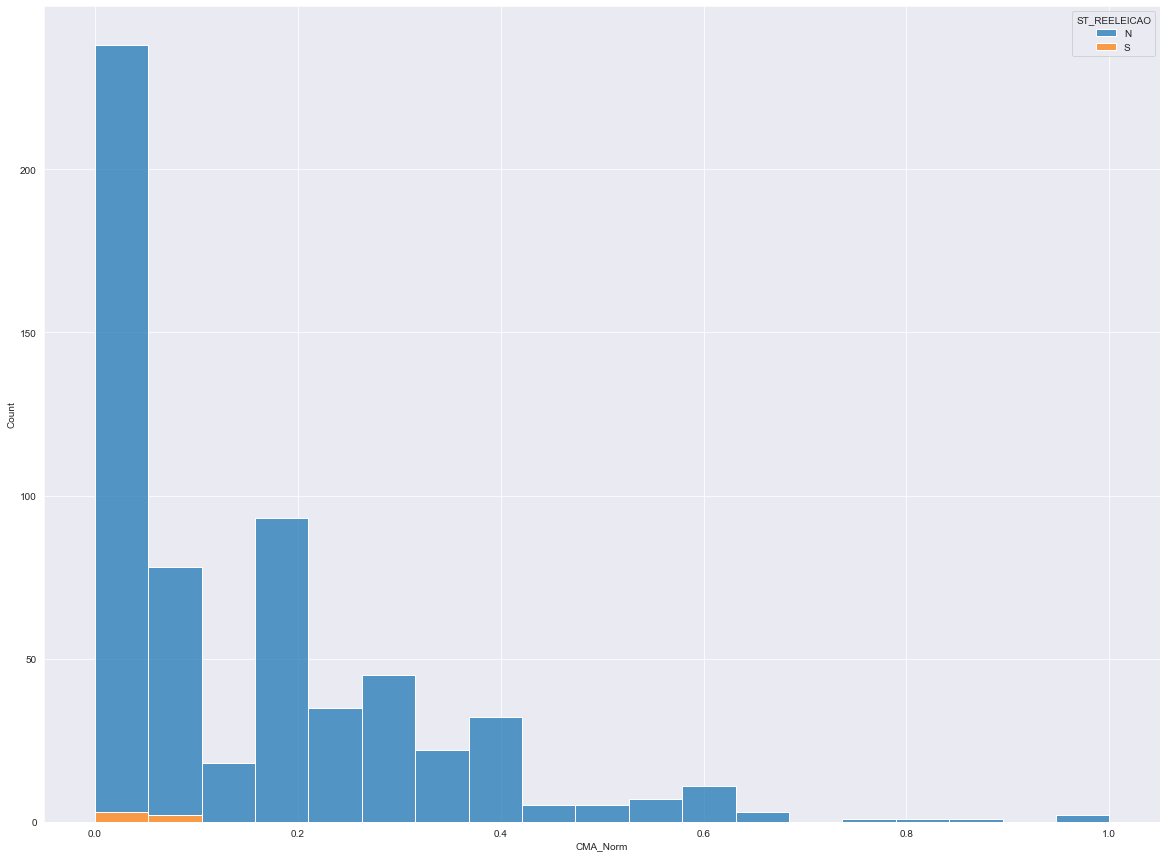

In [9]:
#Plotar os Resultados
import seaborn as sns

# Distinção entre candidatos incumbentes (procurando reeleição) e os candidatos em geral. 
sns.set_style('darkgrid')
sns.color_palette('Paired')
plt.figure(figsize=(20,15))
sns.histplot(data=cv, x='CMA_Norm', hue='ST_REELEICAO', multiple='stack')

### Distribuição dos candidatos, entre eleitos e não eleitos, por custo marginal agregado

<AxesSubplot:xlabel='CMA_Norm', ylabel='Count'>

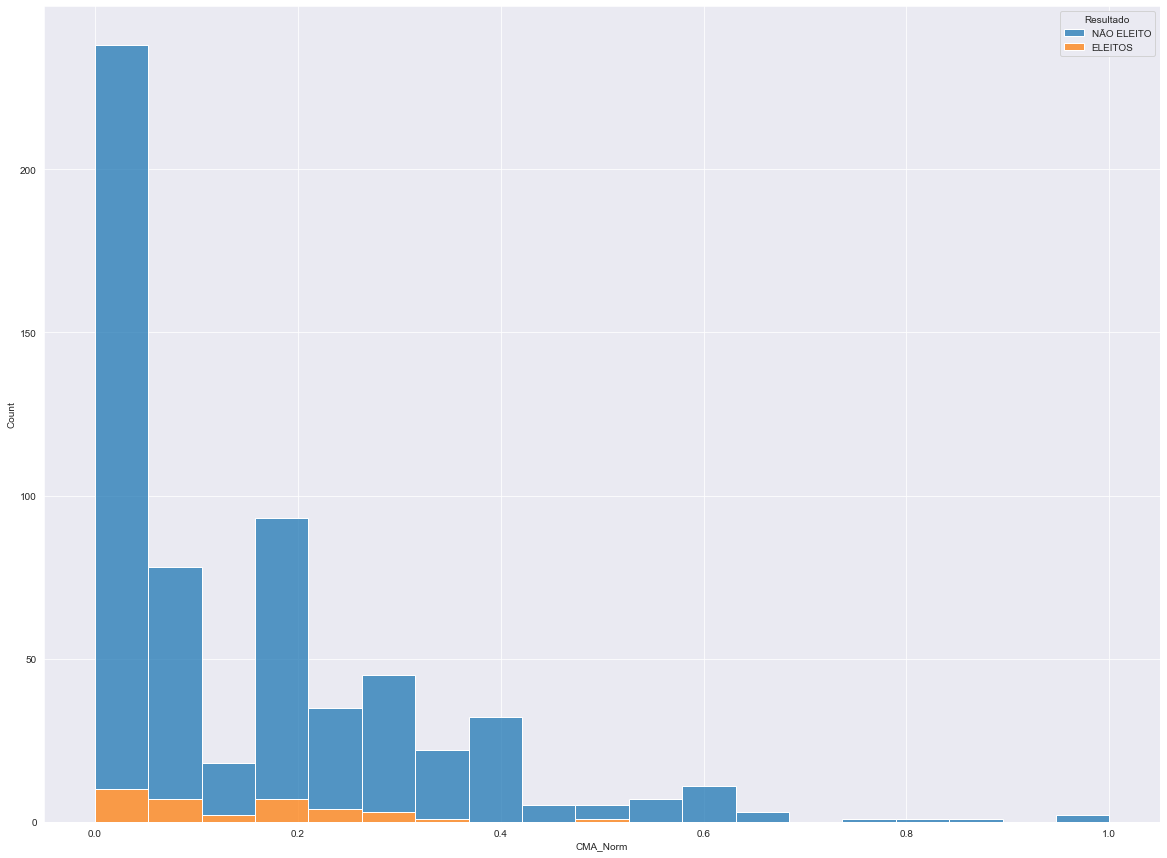

In [20]:
#Distinção entre eleitos e não eleitos
cv = cv.replace(['ELEITO POR QP','ELEITO POR MÉDIA','ELEITO'],'ELEITOS')
cv = cv.replace(['SUPLENTE','#NULO#','2º TURNO'], 'NÃO ELEITOS')

plt.figure(figsize=(20,15))
sns.histplot(data=cv, x='CMA_Norm', hue='Resultado', multiple='stack')

### Distribuição dos candidatos, por custo marginal do candidato e custo marginal do partido

<AxesSubplot:xlabel='CMC_Norm', ylabel='CMP_Norm'>

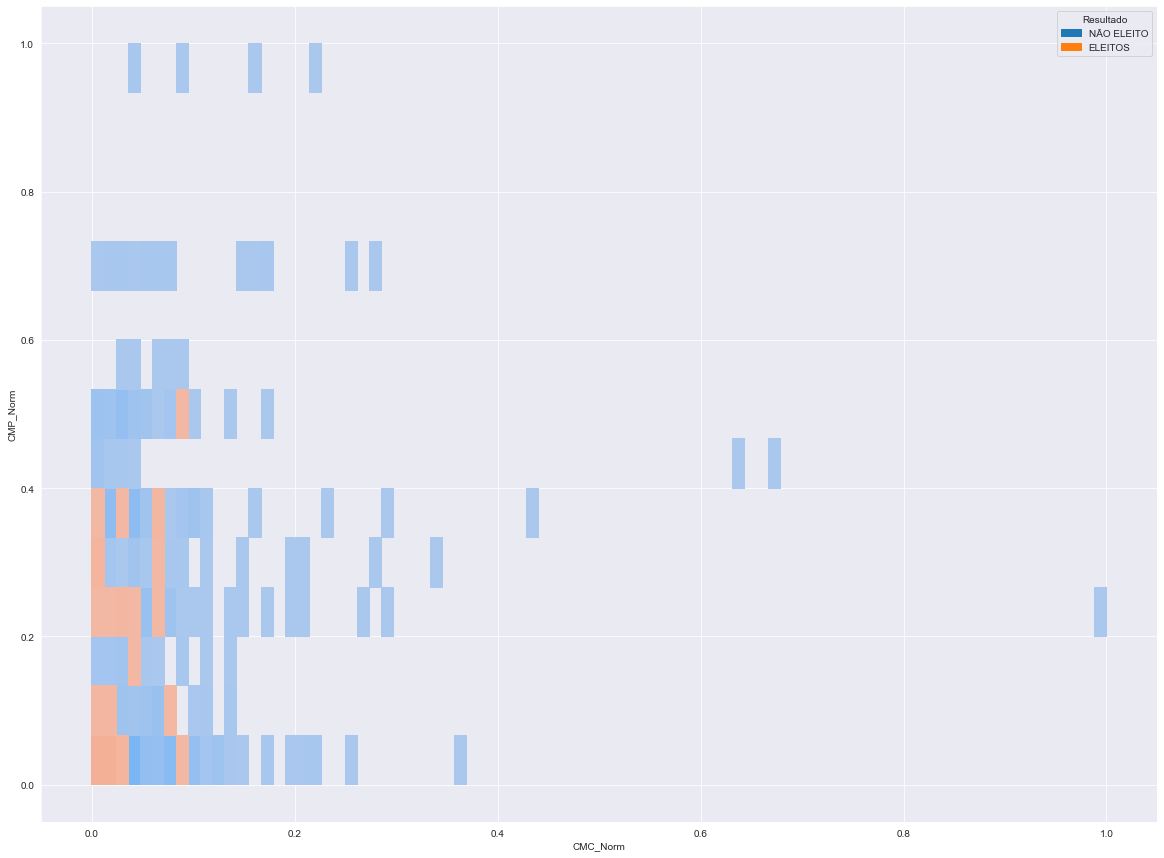

In [24]:
#Distinção entre eleitos e não eleitos
plt.figure(figsize=(20,15))
sns.histplot(data=cv, x='CMC_Norm', y='CMP_Norm', hue='Resultado', multiple='stack')

### Distribuição dos custos marginais dos candidatos, por partido

<AxesSubplot:xlabel='CMC_Norm', ylabel='SG_PARTIDO'>

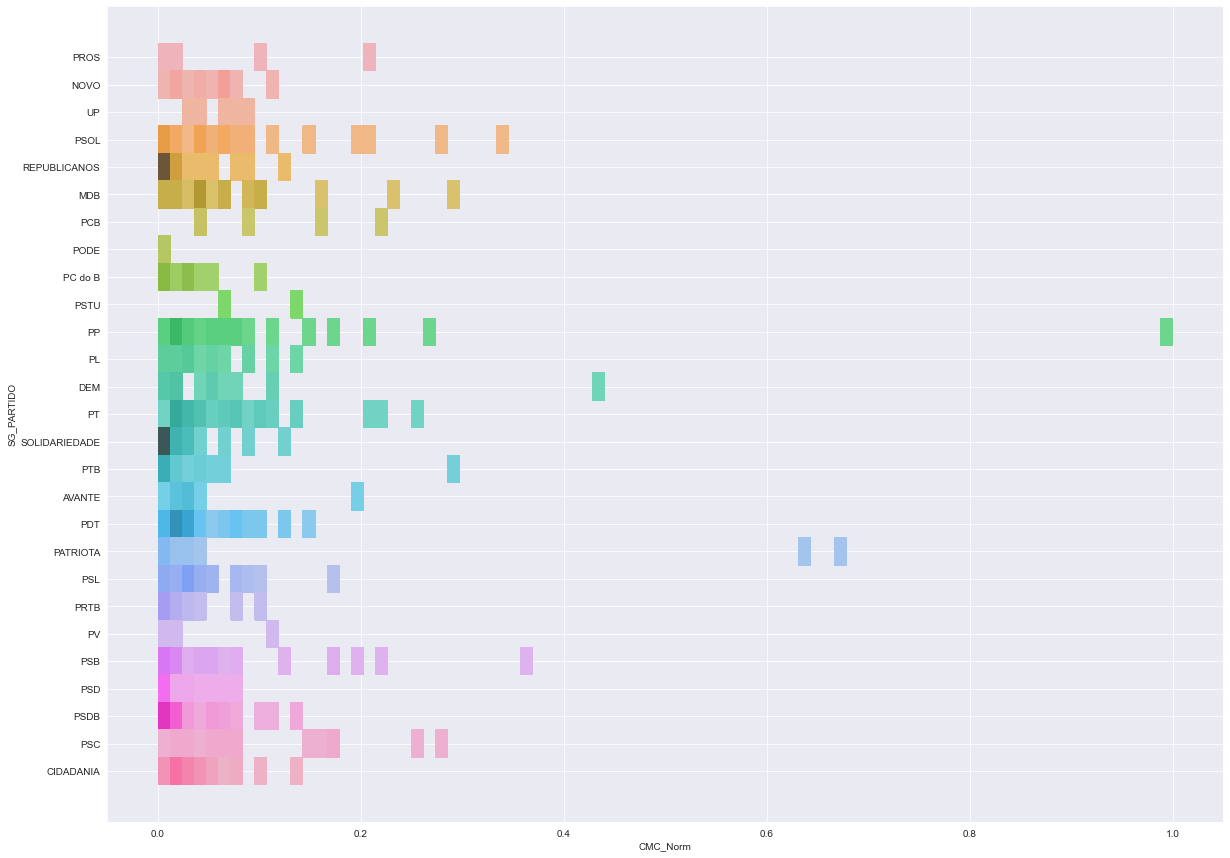

In [11]:
#Distribuição dos custos marginais dos candidatos, por partido
plt.figure(figsize=(20,15))
sns.color_palette('Paired')
sns.histplot(cv, x="CMC_Norm", y="SG_PARTIDO", hue="SG_PARTIDO", legend=False)

### Distribuição dos custos marginais dos candidatos, por partido, distinguido por eleitos e não eleitos

<AxesSubplot:xlabel='CMC_Norm', ylabel='SG_PARTIDO'>

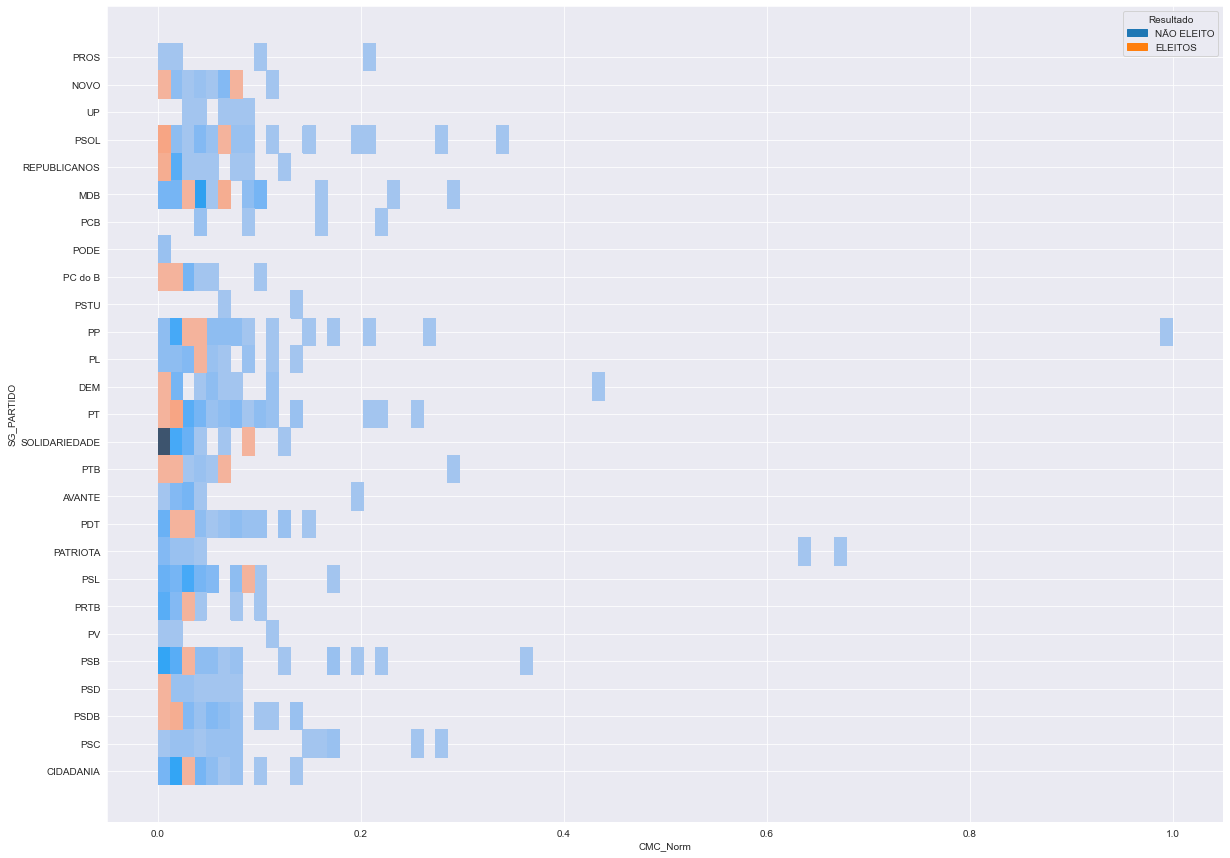

In [21]:
#Distribuição dos custos marginais dos candidatos, por partido, distinguido por eleitos e não eleitos
plt.figure(figsize=(20,15))
sns.color_palette('Paired')
sns.histplot(cv, x="CMC_Norm", y="SG_PARTIDO", hue='Resultado')

### Distribuição dos custos marginais agregados dos candidatos, por partido

<AxesSubplot:xlabel='CMA_Norm', ylabel='SG_PARTIDO'>

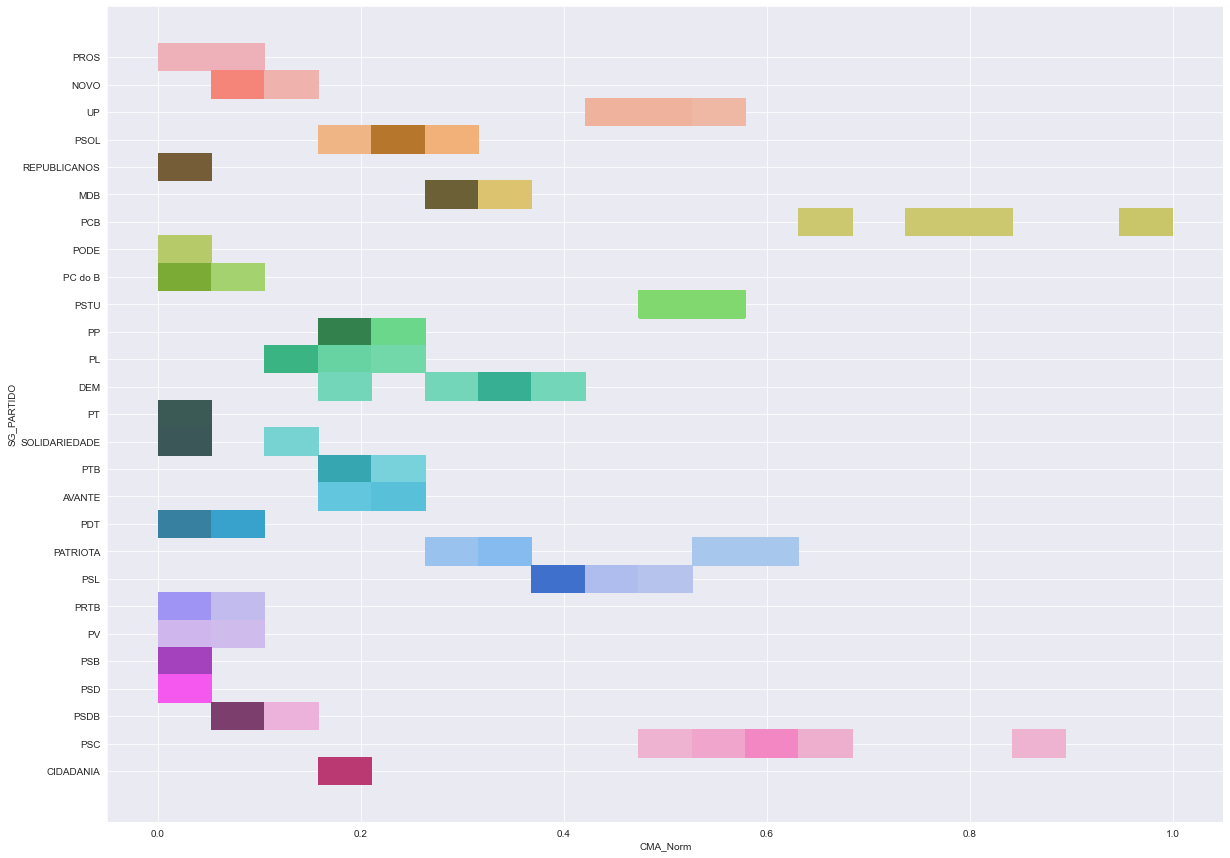

In [13]:
#Distribuição dos custos marginais agregados, por partido
plt.figure(figsize=(20,15))
sns.color_palette('Paired')
sns.histplot(cv, x="CMA_Norm", y="SG_PARTIDO", hue="SG_PARTIDO", legend=False)


### Distribuição dos custos marginais agregados dos candidatos, por partido, entre eleitos e não eleitos

<AxesSubplot:xlabel='CMA_Norm', ylabel='SG_PARTIDO'>

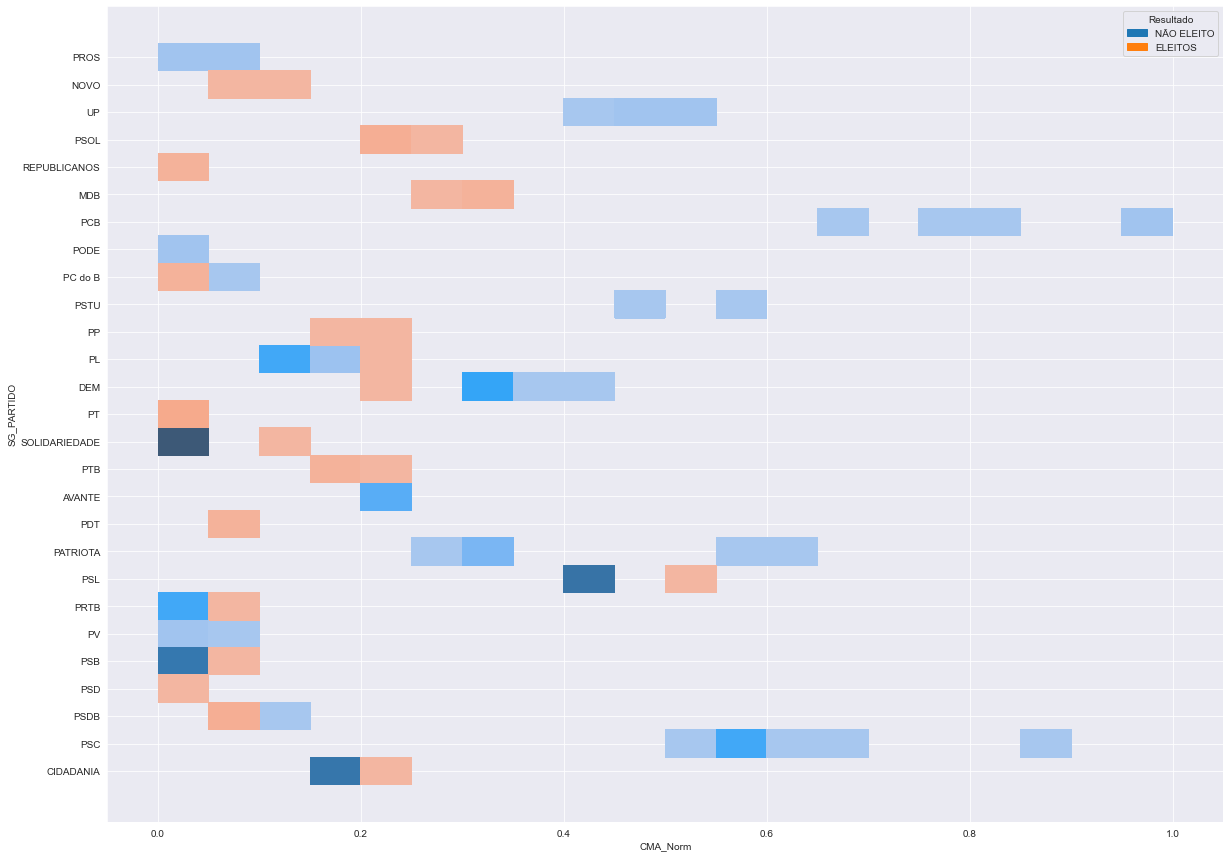

In [26]:
#Distribuição dos custos marginais agregados, por partido, distinguido por eleitos e não eleitos
plt.figure(figsize=(20,15))
sns.color_palette('Paired')
sns.histplot(cv, x="CMA_Norm", y="SG_PARTIDO", hue='Resultado', bins=20)

# Avaliando a qualidade do indicador

Afinal, quão bom é o indicador de custo marginal agregado em comparação com o simples custo por voto? 

A melhor forma de obter essa resposta é comparar o quanto cada um dos indicadores consegue corretamente avaliar a perfomance dos candidatos. Candidatos eleitos, por definição, tem as melhores performances. 

### Observações Iniciais

Como vemos no primeiro gráfico abaixo, de maneira agregada, ainda que seu impacto não seja altamente significativo, o uso do Custo Marginal do Candidato apresenta um fator de correção interessante. 

Mais especificamente, vemos que os candidatos eleitos se tornam mais competitivos para os doadores pois, apesar de eventualmente não serem os mais baratos, faltam menos votos para que eles atinjam o coeficiente eleitoral.

O indicador de Custo Marginal do Candidato, portanto, ajuda a identificar candidatos mais competitivos. 

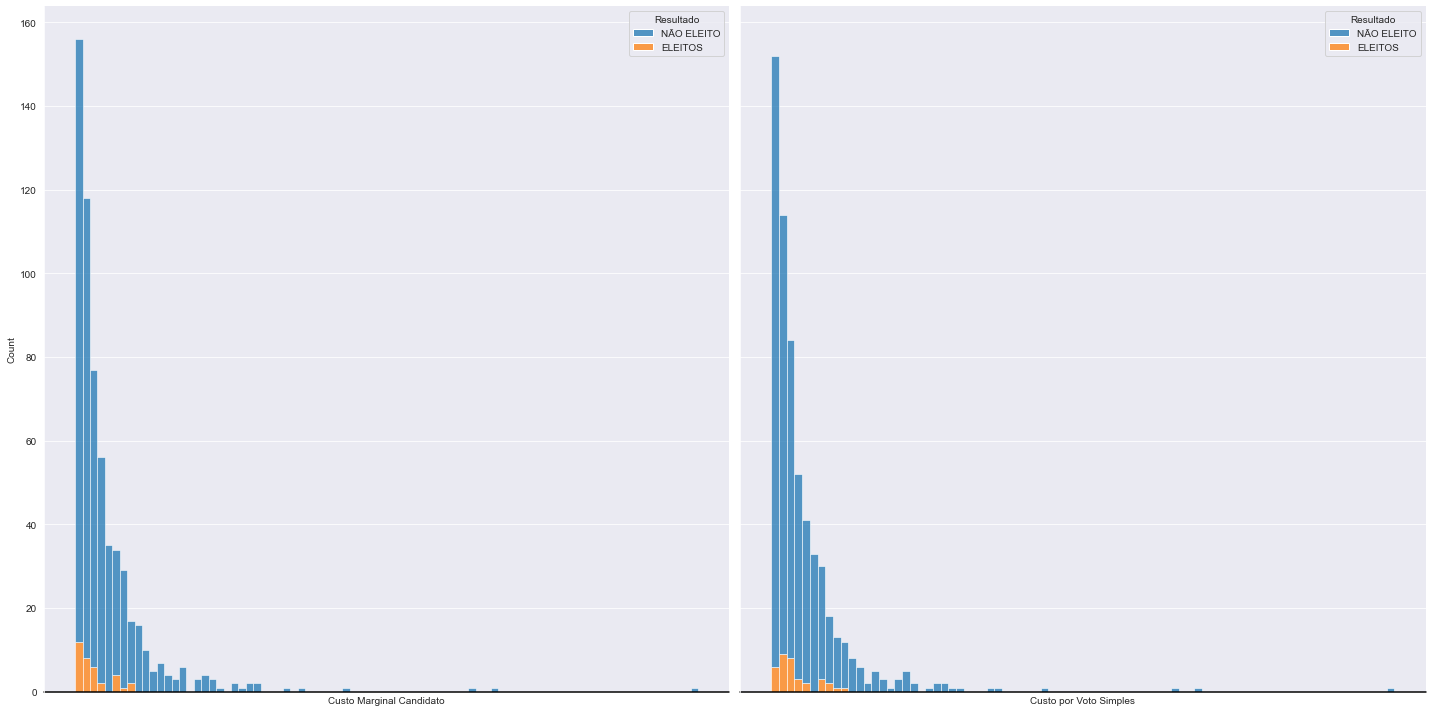

In [58]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

max_cvc = cv['CVC'].max()
min_cvc = cv['CVC'].min()
cv['CVC_Norm'] = (cv['CVC'] - min_cvc) / (max_cvc - min_cvc)


# Generate some sequential data
sns.histplot(data=cv, x='CMC_Norm', hue='Resultado', multiple='stack', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_xlabel("Custo Marginal Candidato")

# Center the data to make it diverging
sns.histplot(data=cv, x='CVC_Norm', hue='Resultado', multiple='stack', ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_xlabel("Custo por Voto Simples")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, xticks=[])
plt.tight_layout(h_pad=2)

Nesse segundo gráfico o fator de ajuste fica mais claro. Em casos como o do Partido Novo, ou do PSDB, os candidatos eleitos se tornam os  mais competitivos graças ao ajuste.

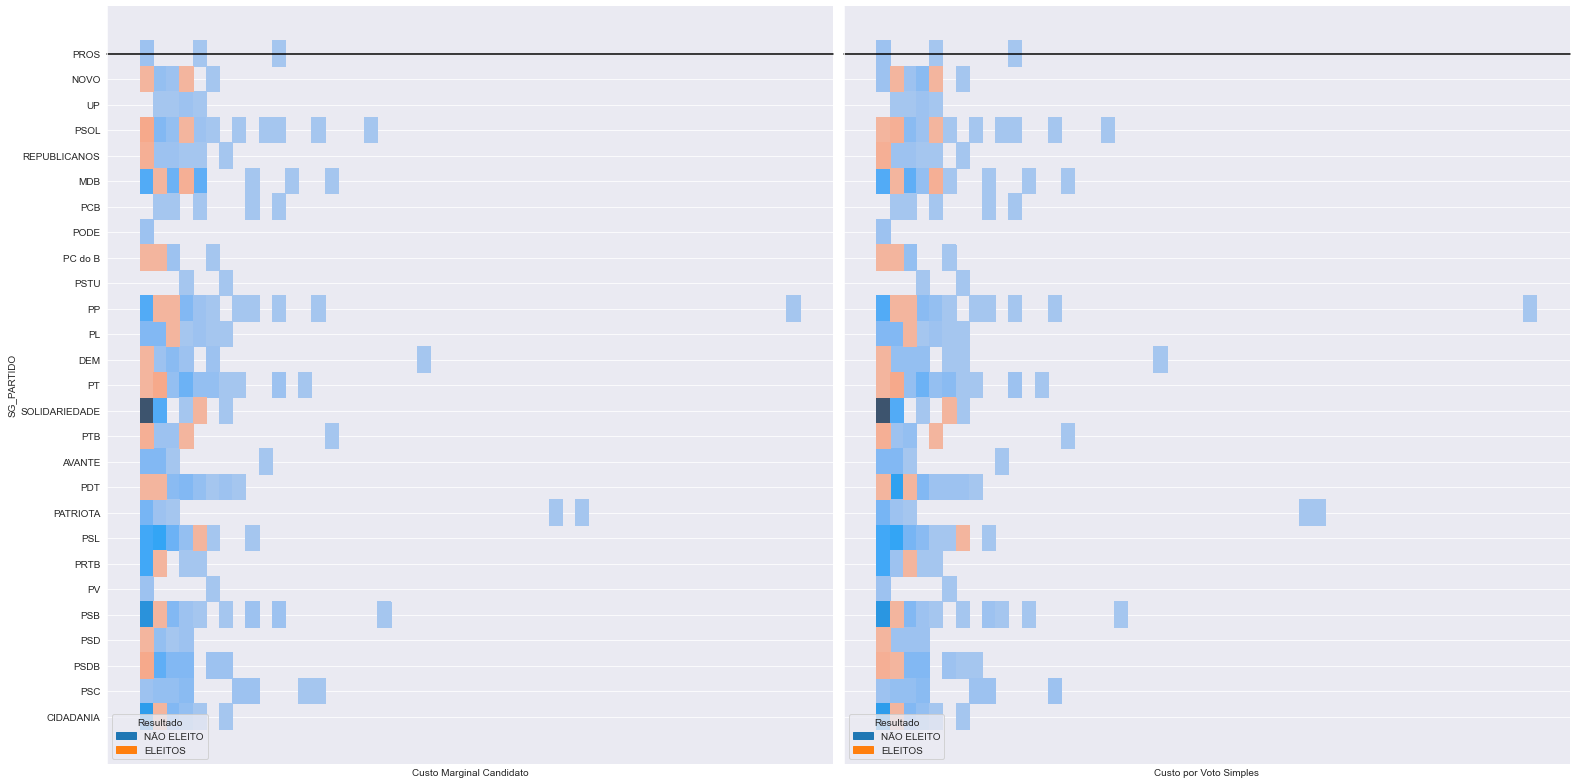

In [69]:
# Set up the matplotlib figure
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(22, 11), sharey=True)

# Plot 1 - Custo Marginal Candidato
sns.histplot(data=cv, x='CMC_Norm', y="SG_PARTIDO", hue='Resultado', bins=50, multiple='stack', ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_xlabel("Custo Marginal Candidato")

# Plot 2 - Custo por Voto Simples
sns.histplot(data=cv, x='CVC_Norm', y="SG_PARTIDO", hue='Resultado', bins=50, multiple='stack', ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_xlabel("Custo por Voto Simples")


# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, xticks=[])
plt.tight_layout(h_pad=2)

# Vantagens do Custo Marginal Agregado

Aqui podemos ver qual os grandes diferenciais do nosso Indicador em relação ao simples Custo por Voto. 

## 1º - Maior variabilidade

Analisar apenas o custo do voto _dos candidatos_ corretamente ressalta os candidatos eleitos como os mais competitivos; ainda assim, de modo geral, coloca todos os candidatos muito próximos uns dos outros, não sendo efetivo para avaliar candidatos destoantes – sejam os especialmente caros, ou especialmente baratos. 

Um bom exemplo a ser notado abaixo é o caso do Vereador eleito do PSL. Ainda que ele ainda tenha sido o vereador eleito mais caro em ambos os cenários, na análise simples ele parece muito mais próximo dos dos demais eleitos, dando a impressão que a diferença é trivial. 


## 2º Melhor comparação entre candidatos de diferentes partidos

Analisar apenas o custo por voto individual dos candidatos pode incorretamente informar que dois candidatos com mesmo custo por voto são igualmente competitivos. No entanto, o candidato mais competitivo será, na verdade, o que está em um partido mais competitivo em relação aos outros.

No gráfico à direita, abaixo, a impressão é que os candidatos do MDB e do Novo parecem ter candidatos igualmente competitivos em termos de custo. No entanto, o Novo não apenas está muito mais próximo de conseguir uma terceira cadeira do que o MDB como faria isso de maneira mais barata. 

Podemos ver também o peso do fundo partidários em partidos que são altamente dependentes deste, como o MDB e o PSOL.

O PCB é outro bom exemplo. Todos seus candidatos parecem estar em pé de competitividade inclusive com outros candidatos (inclusive alguns eleitos), mas isso acontece simplesmente porque suas campanhas são relativamente baratas. Com o Custo Marginal Agregado, eles estão entre os candidatos menos competitivos, pois seu partido está extremamente longe de atingir o Coeficiente Eleitoral e conquistar uma cadeira. 

## 3º Melhor comparação de competitividade entre partidos

Por fim, pela metodologia do Custo Marginal Agregado, se resolvem dois problemas adicionais. 

Primeiro, a competitividade entre partidos. Note o PSL, novamente. Caso o PSL quisesse fazer mais uma cadeira, seria bastante dificil que ela fosse uma cadeira barata. Isso porque o peso do candidato com mais votos será maior e portanto com mais peso no custo médio de votos do partido. Todos os vereadores do partido tornam-se menos competitivos no caminho para atingir o coeficiente eleitoral. 

Segundo, vemos as tendências intra-partido. Veja o PP ou o MDB em ambos os gráficos. Ficam significativamente mais concentrados pois menos peso aos candidatos com votações pequenas. Esses são justamente dois partidos que acabam por atingir o coeficiente eleitoral por ter um volume enorme de candidatos que, individualmente, impactam pouco no agregado do partido. 

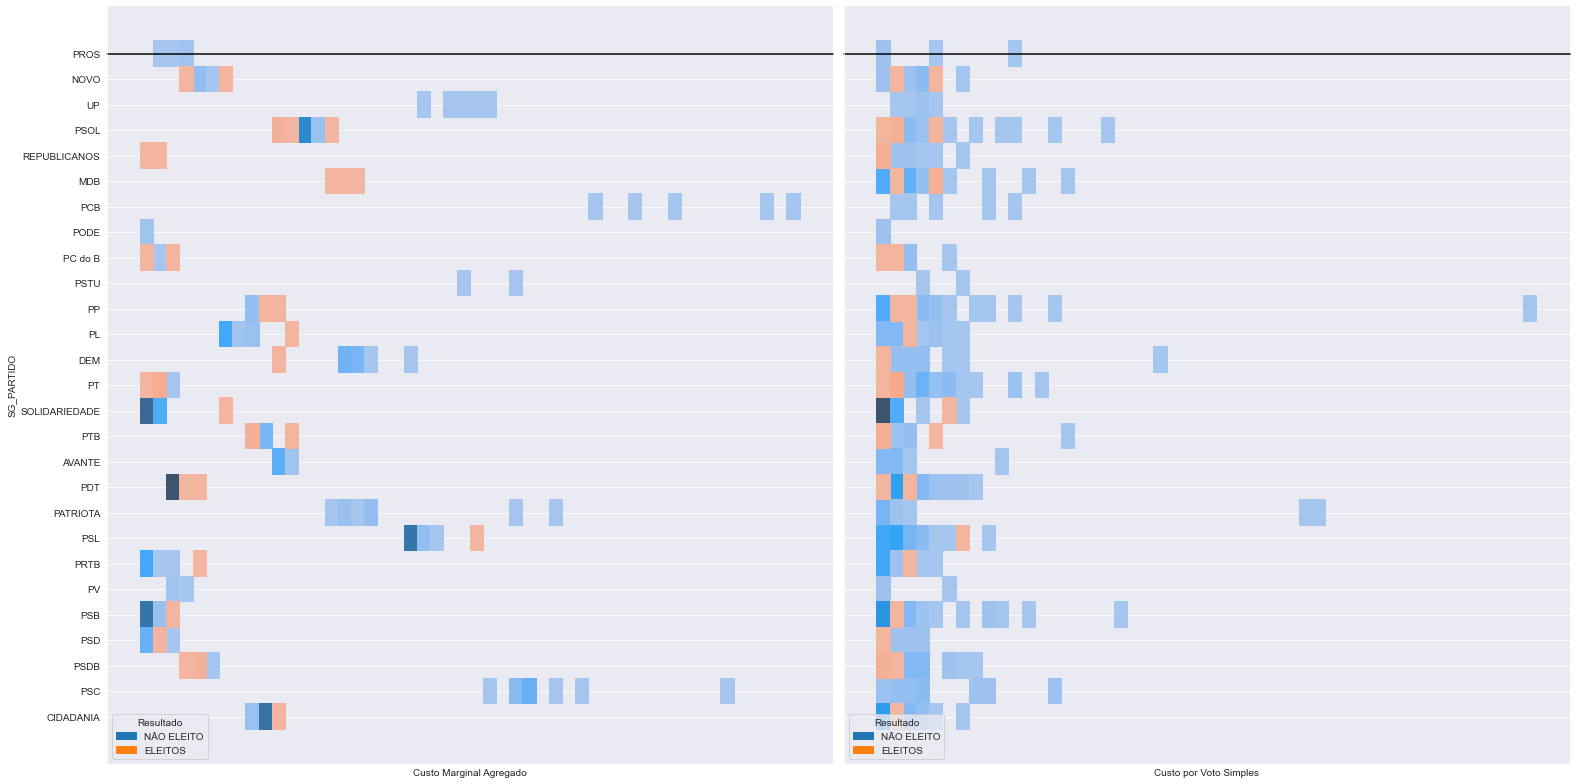

In [70]:
# Set up the matplotlib figure
f, (ax5, ax6) = plt.subplots(1, 2, figsize=(22, 11), sharey=True)

# Plot 1 - Custo Marginal Candidato
sns.histplot(data=cv, x='CMA_Norm', y="SG_PARTIDO", hue='Resultado', bins=50, multiple='stack', ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_xlabel("Custo Marginal Agregado")

# Plot 2 - Custo por Voto Simples
sns.histplot(data=cv, x='CVC_Norm', y="SG_PARTIDO", hue='Resultado', bins=50, multiple='stack', ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_xlabel("Custo por Voto Simples")


# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, xticks=[])
plt.tight_layout(h_pad=2)

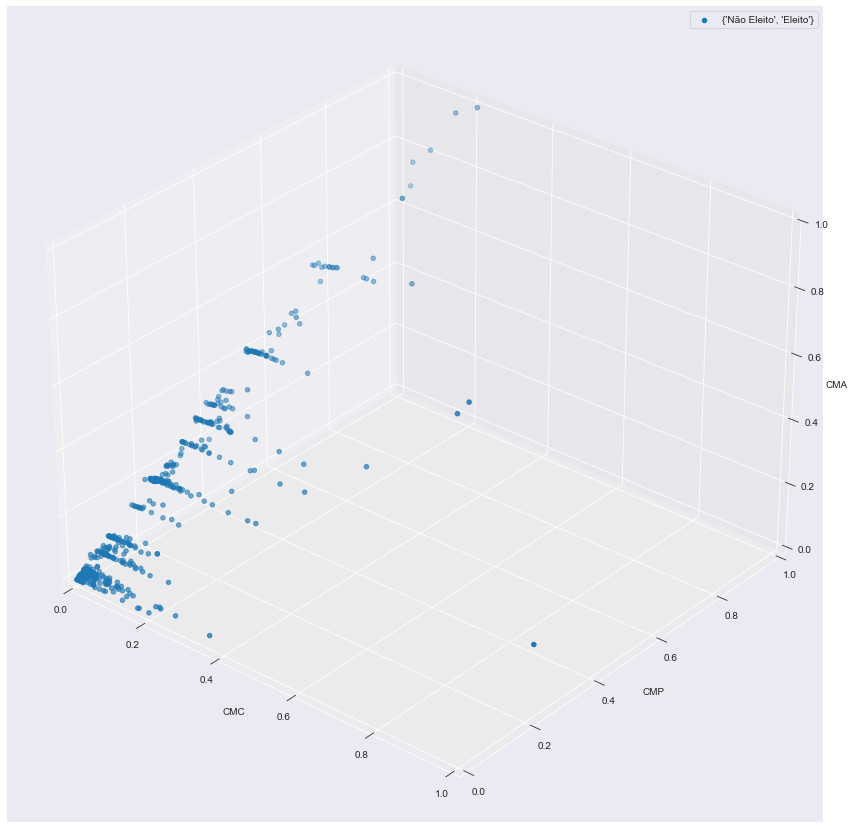

In [91]:
ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')

ax.scatter(cv['CMC_Norm'], cv['CMP_Norm'], 
               cv['CMA_Norm'], zdir='z',label={'Eleito', 'Não Eleito'})

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('CMC')
ax.set_ylabel('CMP')
ax.set_zlabel('CMA')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=30., azim=-50)

plt.show()